# 📦 OR-01: Cálculo de stock de seguridad

Cálculo del stock de seguridad utilizando fórmulas clásicas y análisis estadístico.

## 📦 Instalación de Librerías Necesarias

**Antes de ejecutar este notebook, asegúrate de tener instaladas todas las dependencias.**

### Opción 1: Instalación dentro del notebook
Ejecuta la siguiente celda para instalar las librerías necesarias:

```python
%pip install pandas numpy scipy matplotlib seaborn
```

### Opción 2: Instalación desde terminal
Si prefieres instalar desde la terminal, ejecuta:

```bash
# PowerShell o CMD
pip install pandas numpy scipy matplotlib seaborn

# O si usas el proyecto completo con pyproject.toml
pip install -e .[core,notebooks,or]
```

### Librerías requeridas:
- `pandas`: Manipulación y análisis de datos
- `numpy`: Cálculos numéricos y arrays
- `scipy`: Funciones estadísticas y científicas (Z-scores)
- `matplotlib`: Visualización estática
- `seaborn`: Visualización estadística avanzada

---

In [4]:
# ⚙️ Preparación de entorno y rutas
# Si esta celda tarda demasiado o se cuelga:
# 1) Abre la paleta de comandos (Ctrl+Shift+P)
# 2) "Jupyter: Restart Kernel"
# 3) "Run All Above/Below" o ejecuta desde la primera celda

import sys
from pathlib import Path

# Detectar raíz del repo (buscando pyproject.toml o carpeta src)
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()

if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))

print(f"✅ Entorno listo. Raíz del repo: {_repo_root}")

✅ Entorno listo. Raíz del repo: f:\GitHub\supply-chain-data-notebooks


# OR-01: Cálculo de Stock de Seguridad

## 📋 Contexto del Caso de Negocio

**Empresa:** "FarmaSalud" - Distribuidora farmacéutica con 15 productos críticos (insulina, anticoagulantes, antiepilépticos).

**Situación:** 
- **Problema actual:** Rupturas de stock en medicamentos vitales causan pérdida de ventas y riesgo para pacientes
- **Causa raíz:** Variabilidad en demanda (picos en temporada de gripe) y lead time de proveedores internacionales (7-21 días)
- **Dilema:** Mucho inventario inmoviliza capital (costo oportunidad 18%/año) vs poco inventario genera quiebres

**Objetivo:** Calcular el **stock de seguridad óptimo** para cada SKU crítico que balancee:
- **Nivel de servicio objetivo:** 98% (solo 2% riesgo de quiebre)
- **Costo de mantener inventario:** Minimizar capital inmovilizado
- **Variabilidad:** Absorber fluctuaciones de demanda y lead time

---

## 🎯 Qué - Por qué - Para qué - Cuándo - Cómo

### ❓ ¿QUÉ estamos haciendo?
Calculando el **stock de seguridad (SS)** usando tres enfoques:
1. **Fórmula básica:** `SS = Z * σ_demanda * √(Lead_Time)`
2. **Variabilidad en demanda Y lead time:** `SS = Z * √(LT_avg * σ_D² + D_avg² * σ_LT²)`
3. **Análisis de sensibilidad:** Impacto de cambios en nivel de servicio y variabilidad

Donde:
- **Z:** Factor de seguridad (Z-score) según nivel de servicio deseado
- **σ_demanda:** Desviación estándar de la demanda diaria
- **Lead Time (LT):** Tiempo de reaprovisionamiento en días

### 🔍 ¿POR QUÉ es importante?
- **Salva vidas:** En farmacéuticas, un quiebre de insulina puede ser mortal
- **Eficiencia de capital:** Evita exceso de inventario (costo típico: 20-30% del valor/año)
- **Competitividad:** Fill rate alto (>98%) diferencia a distribuidores premium
- **Cumplimiento regulatorio:** Farmacias deben garantizar disponibilidad de medicamentos esenciales

### 🎁 ¿PARA QUÉ sirve?
- **Políticas de reorden:** Definir punto de reorden = Demanda durante LT + SS
- **Negociación con proveedores:** Justificar pedidos de seguridad o lead times
- **Presupuesto de inventario:** Estimar capital inmovilizado necesario
- **Análisis de riesgo:** Cuantificar probabilidad de quiebre vs costo

### ⏰ ¿CUÁNDO aplicarlo?
- **Variabilidad alta:** Cuando demanda o lead time fluctúan significativamente (CV > 0.3)
- **Costo de quiebre alto:** Productos críticos, ventas perdidas caras, penalizaciones
- **Lead times largos:** >5 días aumenta exposición a incertidumbre
- **Revisión periódica:** Cada 3-6 meses o ante cambios en demanda/proveedor

### 🛠️ ¿CÓMO lo hacemos?
1. **Extraer histórico:** Demanda diaria por SKU (mínimo 90 días)
2. **Calcular estadísticas:** Media y desviación estándar de demanda
3. **Definir nivel de servicio:** Según criticidad del producto (95-99.9%)
4. **Obtener Z-score:** Tabla normal estándar
5. **Calcular SS:** Aplicar fórmulas según variabilidad conocida
6. **Validar:** Simular escenarios históricos
7. **Ajustar:** Análisis de sensibilidad y trade-offs

---\nid: "OR-01"\ntitle: "Cálculo de stock de seguridad"\nspecialty: "Operations Research"\nprocess: "Optimize"\nlevel: "Intermediate"\ntags: ["inventory", "safety-stock", "optimization"]\nestimated_time_min: 45\n---\n

In [5]:
# Imports necesarios
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 📚 LIBRERÍAS CLAVE PARA OPTIMIZACIÓN DE INVENTARIOS:
#
# scipy.stats: Distribuciones estadísticas y Z-scores
#   - norm.ppf(percentile): calcula Z-score para nivel de servicio
#   - norm.cdf(z): probabilidad acumulada (útil para validación)
#   - Ejemplo: Z=1.65 → 95% servicio, Z=2.33 → 99% servicio
#
# numpy: Operaciones matemáticas vectorizadas
#   - sqrt(), square() para fórmulas de SS
#   - random.seed(42) para reproducibilidad
#   - Cálculos rápidos sobre arrays grandes
#
# 🔍 CONCEPTO: warnings.filterwarnings('ignore')
# Suprime advertencias de convergencia, deprecated features, etc.
# ⚠️ CUIDADO: Solo usar en notebooks pedagógicos.
# En producción, SIEMPRE revisar warnings (pueden indicar problemas reales)

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# 🎨 CONFIGURACIÓN DE VISUALIZACIÓN:
# rcParams: parámetros globales de matplotlib
# - figure.figsize: tamaño default de figuras (ancho, alto en pulgadas)
# - (14, 6) = tamaño panorámico ideal para comparaciones lado a lado
# - Otros útiles: font.size, axes.titlesize, lines.linewidth

print("✅ Librerías cargadas")

✅ Librerías cargadas


## 📥 Paso 1: Cargar y analizar datos de demanda histórica

In [ ]:
# Cargar datos
data_path = Path('../../data/raw')
df_orders = pd.read_csv(data_path / 'orders.csv')
df_orders['date'] = pd.to_datetime(df_orders['date'])
df_products = pd.read_csv(data_path / 'products.csv')

# 📚 CONCEPTO: pd.to_datetime()
# Convierte strings de fechas a objetos datetime de pandas.
# ¿Por qué es crítico?
# - Permite operaciones temporales: filtrar rangos, calcular diferencias de días
# - Habilita resampling: agrupar por día/semana/mes
# - Mejora rendimiento vs comparar strings
#
# Ejemplo de operaciones habilitadas:
#   df_orders['date'].dt.dayofweek → día de la semana (0=Lunes)
#   df_orders['date'].dt.month → mes (1-12)
#   (df_orders['date'].max() - df_orders['date'].min()).days → días totales

# Simular categoría farmacéutica para productos críticos
np.random.seed(42)
critical_skus = df_products.sample(15)['sku'].tolist()

# 🎲 CONCEPTO: Simulación con seed fija
# np.random.seed(42) garantiza reproducibilidad:
# - Cada ejecución selecciona los mismos 15 SKUs "aleatorios"
# - Crítico para notebooks pedagógicos y debugging
# - 42 es convención (referencia "Hitchhiker's Guide to the Galaxy")
#
# 💡 EN PRODUCCIÓN:
# - NO usar seed fijo (queremos aleatoriedad real)
# - O generar múltiples muestras (Monte Carlo) para robustez

# Filtrar solo productos críticos
df_critical = df_orders[df_orders['sku'].isin(critical_skus)].copy()

# 📚 CONCEPTO: .copy()
# Crea copia independiente del DataFrame para evitar SettingWithCopyWarning.
# Sin .copy(), modificaciones pueden afectar df_orders original (efecto secundario).
# REGLA: Siempre usar .copy() cuando filtras y planeas modificar el resultado.

print(f"📦 Órdenes de productos críticos: {len(df_critical):,}")
print(f"📊 SKUs críticos: {len(critical_skus)}")
print(f"📅 Período: {df_critical['date'].min().date()} a {df_critical['date'].max().date()}")
print(f"📅 Días de historia: {(df_critical['date'].max() - df_critical['date'].min()).days}")

# 💡 VALIDACIÓN DE DATOS:
# Verificar que tengamos suficiente historia para estadísticas confiables:
# - Mínimo recomendado: 60-90 días (2-3 ciclos de lead time)
# - Ideal: 12+ meses para capturar estacionalidad
# - Alerta si días < 30: estadísticas poco confiables

📦 Órdenes de productos críticos: 611
📊 SKUs críticos: 15
📅 Período: 2024-01-01 a 2024-03-31
📅 Días de historia: 90


In [ ]:
# Agregar demanda diaria por SKU
daily_demand = df_critical.groupby(['sku', 'date'])['qty'].sum().reset_index()
daily_demand.columns = ['sku', 'date', 'demand']

# 📚 CONCEPTO: Agregación Temporal
# groupby(['sku', 'date']).sum() consolida múltiples órdenes del mismo SKU en un día.
# ¿Por qué es necesario?
# - Un SKU puede tener varias órdenes en un día (diferentes clientes/canales)
# - Fórmulas de SS requieren demanda diaria agregada, no órdenes individuales
# - Ejemplo: 3 órdenes de 10, 15, 8 units → demanda_día = 33 units

# Calcular estadísticas de demanda por SKU
demand_stats = daily_demand.groupby('sku')['demand'].agg([
    ('mean_demand', 'mean'),
    ('std_demand', 'std'),
    ('cv_demand', lambda x: x.std() / x.mean()),  # Coeficiente de variación
    ('min_demand', 'min'),
    ('max_demand', 'max'),
    ('count_days', 'count')
]).round(2)

# 📚 CONCEPTO: Coeficiente de Variación (CV)
# CV = σ / μ = desviación estándar / media
# 
# Interpreta variabilidad relativa (vs absoluta):
# - CV < 0.3: Baja variabilidad → demanda predecible → SS baja
# - 0.3 ≤ CV < 0.6: Variabilidad media → SS moderada
# - CV ≥ 0.6: Alta variabilidad → demanda errática → SS alta
#
# 💡 VENTAJA sobre σ sola:
# - SKU A: μ=100, σ=20 → CV=0.20 (predecible)
# - SKU B: μ=10, σ=6 → CV=0.60 (muy errático)
# σ similar, pero comportamientos muy diferentes.
#
# 🎯 APLICACIÓN EN SS:
# - CV alto → considerar métodos no paramétricos (quantiles, simulación)
# - CV bajo → fórmula básica de SS funciona bien
# - CV > 1.0 → posible demanda intermitente → usar Croston o TSB

# Merge con info de productos
demand_stats = demand_stats.merge(
    df_products[['sku', 'category', 'brand', 'unit_cost']], 
    left_index=True, 
    right_on='sku'
).set_index('sku')

# Crear nombre descriptivo del producto
demand_stats['product_name'] = demand_stats['brand'] + ' ' + demand_stats['category']

# 📚 CONCEPTO: Enriquecimiento de datos
# Merge con df_products agrega contexto de negocio:
# - category/brand: para segmentación y reporting
# - unit_cost: para calcular valor de inventario ($)
# - product_name: para visualizaciones legibles
#
# 💡 BEST PRACTICE:
# Siempre vincular datos operacionales (órdenes) con maestros (productos)
# para análisis más ricos y toma de decisiones informada.

print("📊 Estadísticas de Demanda por SKU Crítico:\n")
print(demand_stats[['product_name', 'mean_demand', 'std_demand', 'cv_demand']].head(10))

# Identificar SKU con mayor variabilidad
most_variable_sku = demand_stats['cv_demand'].idxmax()
print(f"\n⚠️ SKU con mayor variabilidad: {most_variable_sku} (CV={demand_stats.loc[most_variable_sku, 'cv_demand']:.2f})")

# 💡 INTERPRETACIÓN:
# El SKU con mayor CV requiere:
# 1. Stock de seguridad más alto (mayor Z-score o buffer)
# 2. Análisis de causas raíz (promociones, estacionalidad, errores de datos)
# 3. Posible segmentación especial (política de inventario diferenciada)
# 4. Considerar estrategias alternativas:
#    - Lead time más corto con proveedor
#    - Pedidos más frecuentes (menor lote, mayor reposición)
#    - Análisis predictivo (ML para anticipar picos)

📊 Estadísticas de Demanda por SKU Crítico:

                  product_name  mean_demand  std_demand  cv_demand
sku                                                               
SKU-00016        BrandC Snacks        12.46        9.70       0.78
SKU-00031  BrandB PersonalCare        11.38       11.44       1.01
SKU-00046     BrandC Beverages        10.09       10.09       1.00
SKU-00067        BrandD Snacks        12.43       10.45       0.84
SKU-00070     BrandD Household        11.00        8.08       0.73
SKU-00079     BrandC Household        12.43        7.45       0.60
SKU-00096  BrandE PersonalCare        11.97       12.03       1.00
SKU-00116   BrandB Electronics        10.24        8.52       0.83
SKU-00129   BrandB Electronics        12.54        8.86       0.71
SKU-00159     BrandA Beverages         8.40        6.09       0.73

⚠️ SKU con mayor variabilidad: SKU-00031 (CV=1.01)


## 📊 Paso 2: Visualizar patrones de demanda

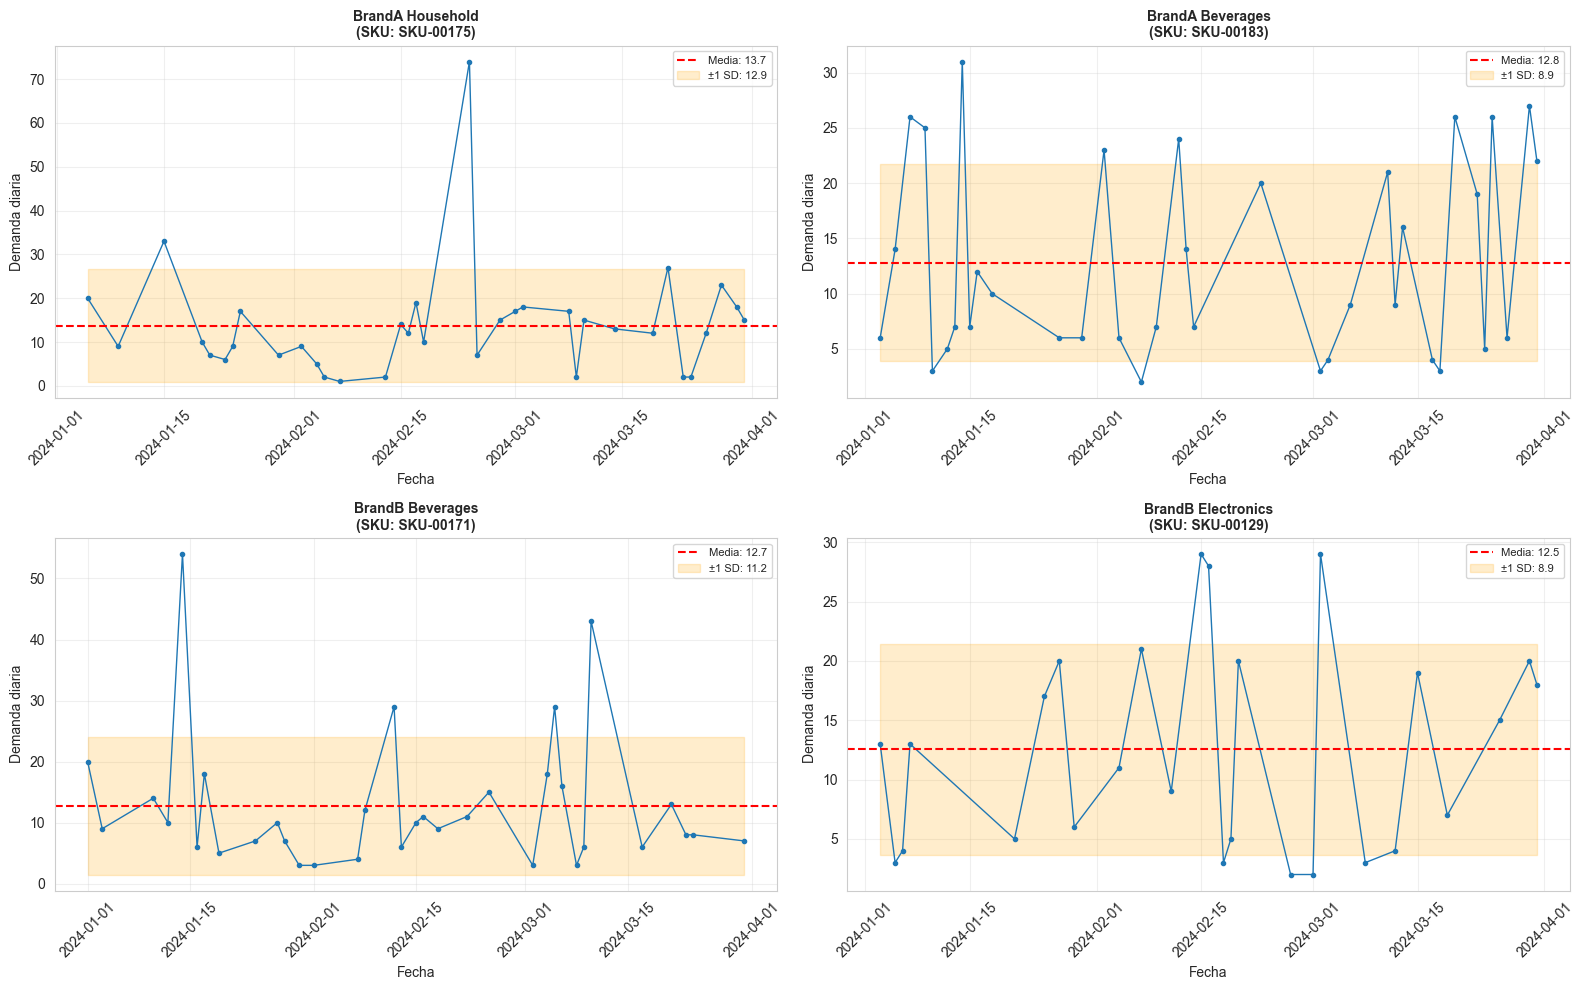

💡 Insight: La banda sombreada muestra la variabilidad esperada (±1 desviación estándar)


In [ ]:
# Seleccionar top 4 SKUs para análisis detallado
top_4_skus = demand_stats.nlargest(4, 'mean_demand').index.tolist()

# 📚 CONCEPTO: Análisis de subconjuntos representativos
# Seleccionamos top 4 por demanda para:
# - Focalizar visualización (16 SKUs sería cluttered)
# - Representar productos de alto volumen (mayor impacto en negocio)
# - Criterios alternativos útiles: mayor valor ($), mayor CV, categorías específicas

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# 🎨 DISEÑO: subplot grid 2×2
# - 4 gráficos en una figura facilita comparación visual
# - flatten() convierte matrix 2D en array 1D para iterar fácilmente
# - figsize=(16, 10) da espacio suficiente para cada subplot

for idx, sku in enumerate(top_4_skus):
    sku_data = daily_demand[daily_demand['sku'] == sku].sort_values('date')
    product_name = demand_stats.loc[sku, 'product_name']
    mean_d = demand_stats.loc[sku, 'mean_demand']
    std_d = demand_stats.loc[sku, 'std_demand']
    
    # Gráfico de serie temporal con banda de variabilidad
    axes[idx].plot(sku_data['date'], sku_data['demand'], marker='o', linewidth=1, markersize=3)
    axes[idx].axhline(y=mean_d, color='red', linestyle='--', label=f'Media: {mean_d:.1f}')
    axes[idx].fill_between(sku_data['date'], mean_d - std_d, mean_d + std_d, 
                           alpha=0.2, color='orange', label=f'±1 SD: {std_d:.1f}')
    
    # 📚 CONCEPTO: Bandas de confianza (Confidence Bands)
    # fill_between(mean ± 1σ) visualiza el rango esperado de demanda.
    # 
    # INTERPRETACIÓN ESTADÍSTICA:
    # - Bajo distribución normal, ~68% de días caen dentro de ±1σ
    # - Días fuera de banda → outliers que requieren investigación
    # - Banda ancha → alta variabilidad → SS alta
    # - Banda angosta → baja variabilidad → SS baja
    #
    # 💡 ANÁLISIS VISUAL:
    # ✅ Serie dentro de banda → comportamiento predecible
    # ⚠️ Serie con picos frecuentes fuera → revisar causas (promociones, errores)
    # ⚠️ Tendencia creciente/decreciente → demanda no estacionaria → ajustar forecast
    #
    # 🎯 PARA STOCK DE SEGURIDAD:
    # Si vemos patrones (días de semana con picos), considerar:
    # - SS variable por día de semana
    # - Forecast más granular (diario vs semanal)
    # - Análisis de estacionalidad (ver notebook DS-02)
    
    axes[idx].set_title(f'{product_name}\n(SKU: {sku})', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Fecha')
    axes[idx].set_ylabel('Demanda diaria')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("💡 Insight: La banda sombreada muestra la variabilidad esperada (±1 desviación estándar)")
print("   Puntos fuera de la banda son outliers que podrían ser:")
print("   - Promociones/campañas")
print("   - Errores de captura de datos")
print("   - Eventos excepcionales (stockouts de competidores, etc.)")

# 🔬 ANÁLISIS AVANZADO RECOMENDADO:
# 1. Test de normalidad (Shapiro-Wilk, Anderson-Darling)
#    → Validar si σ es suficiente o necesitamos percentiles
# 2. Detección de outliers (Z-score > 3, IQR method)
#    → Decidir si excluir o tratar especialmente
# 3. Autocorrelación (ACF/PACF)
#    → Verificar si demanda de hoy depende de ayer (memoria temporal)
# 4. Estacionalidad (descomposición STL)
#    → Ajustar fórmulas de SS si hay patrones recurrentes

## 🎯 Paso 3: Definir parámetros para cálculo de SS

### Tabla de Z-scores según nivel de servicio:

| Nivel Servicio | Z-score | Significado |
|----------------|---------|-------------|
| 90% | 1.28 | 10% riesgo de quiebre |
| 95% | 1.65 | 5% riesgo de quiebre |
| 97% | 1.88 | 3% riesgo de quiebre |
| 98% | 2.05 | 2% riesgo de quiebre |
| 99% | 2.33 | 1% riesgo de quiebre |
| 99.9% | 3.09 | 0.1% riesgo de quiebre |

In [ ]:
# Parámetros de negocio
SERVICE_LEVEL = 0.98  # 98% - Estándar farmacéutico
LEAD_TIME_DAYS = 14   # 2 semanas promedio proveedor internacional
LEAD_TIME_STD = 3     # Variabilidad del lead time
HOLDING_COST_PCT = 0.18  # 18% anual costo de mantener inventario

# 📚 CONCEPTO: Nivel de Servicio (Service Level)
# 
# Probabilidad de NO tener quiebre de stock durante lead time.
# 98% significa: en 100 ciclos de reorden, esperamos solo 2 quiebres.
#
# CÓMO ELEGIR EL NIVEL ADECUADO:
# 
# Alta criticidad (medicamentos vitales, partes clave):
#   - 98-99.9% → Z = 2.05 a 3.09
#   - Justificación: costo de quiebre >>> costo de inventario
#
# Media criticidad (productos regulares):
#   - 95-97% → Z = 1.65 a 1.88
#   - Balance entre disponibilidad y costo
#
# Baja criticidad (commodity, fácil sustitución):
#   - 90-95% → Z = 1.28 a 1.65
#   - Costo de inventario > costo de quiebre ocasional
#
# 💡 TRADE-OFF FUNDAMENTAL:
# Mayor nivel servicio → Mayor Z → Mayor SS → Mayor costo holding
# Cada 0.5 de incremento en Z puede aumentar SS en 30-50%
#
# 🎯 DECISIÓN ESTRATÉGICA:
# En farmacéutica, 98% es conservador pero razonable:
# - Regulación exige alta disponibilidad
# - Reputación crítica (pacientes confían en disponibilidad)
# - Costo de quiebre incluye pérdida de vidas y demandas

# Calcular Z-score
z_score = stats.norm.ppf(SERVICE_LEVEL)

# 📚 CONCEPTO: Z-score (Factor de Seguridad)
#
# stats.norm.ppf(percentile) calcula el Z-score de la distribución normal estándar.
# ppf = Percent Point Function (inversa de CDF)
#
# INTERPRETACIÓN VISUAL:
# Bajo curva normal (campana de Gauss):
#   - Z=0: media (50% a cada lado)
#   - Z=1.65: 95% área a la izquierda, 5% a la derecha
#   - Z=2.05: 98% área a la izquierda, 2% a la derecha
#
# El 2% derecho representa el riesgo de quiebre (demanda > disponibilidad)
#
# 🔍 EJEMPLO NUMÉRICO:
# Si demanda ~ N(μ=100, σ=20) y Z=2.05:
#   Protección hasta: μ + Z×σ = 100 + 2.05×20 = 141 units
#   98% de días la demanda será ≤ 141
#
# ⚠️ SUPUESTO CRÍTICO:
# Fórmula asume demanda con distribución NORMAL.
# Si demanda es muy asimétrica o tiene colas pesadas, considerar:
#   - Usar percentiles empíricos (quantile(0.98)) en vez de Z×σ
#   - Transformación (log, Box-Cox) para normalizar
#   - Métodos no paramétricos (simulación Monte Carlo)

print("⚙️ Parámetros de Cálculo:")
print(f"  Nivel de servicio objetivo: {SERVICE_LEVEL*100}%")
print(f"  Z-score correspondiente: {z_score:.3f}")
print(f"  Lead time promedio: {LEAD_TIME_DAYS} días")
print(f"  Lead time desv. estándar: {LEAD_TIME_STD} días")
print(f"  Costo holding: {HOLDING_COST_PCT*100}% anual")
print(f"\n💡 Interpretación: Con Z={z_score:.2f}, esperamos cubrir el {SERVICE_LEVEL*100}% de escenarios")

# 📊 CONTEXTO DE LEAD TIME:
# Lead time = tiempo desde orden hasta recepción
# - 14 días: típico para importación intercontinental
# - Componentes: procesamiento orden (1-2d) + manufactura (5-7d) + tránsito (5-7d) + customs (1-2d)
# - Variabilidad (σ=3d): delays aduanales, clima, congestión portuaria
#
# 💰 COSTO HOLDING 18% anual:
# Incluye: costo oportunidad capital (10%) + almacenamiento (3%) + obsolescencia (2%) + seguros (3%)
# Farmacéutica suele ser 15-25% (alto por refrigeración y fecha de vencimiento)

⚙️ Parámetros de Cálculo:
  Nivel de servicio objetivo: 98.0%
  Z-score correspondiente: 2.054
  Lead time promedio: 14 días
  Lead time desv. estándar: 3 días
  Costo holding: 18.0% anual

💡 Interpretación: Con Z=2.05, esperamos cubrir el 98.0% de escenarios


## 🧮 Paso 4: Calcular Stock de Seguridad - Método 1 (Básico)

**Fórmula:** `SS = Z × σ_demanda × √(Lead_Time)`

**Supuestos:**
- Lead time constante (sin variabilidad)
- Solo variabilidad en demanda

In [ ]:
# Método 1: Fórmula básica
demand_stats['ss_basic'] = (
    z_score * demand_stats['std_demand'] * np.sqrt(LEAD_TIME_DAYS)
).round(0)

# 📚 FÓRMULA EXPLICADA: SS = Z × σ_D × √(LT)
#
# COMPONENTES:
# 1. Z (factor de seguridad): cuántas desviaciones estándar cubrir
#    - Viene del nivel de servicio deseado
#    - Z=2.05 para 98% servicio
#
# 2. σ_D (desv. estándar demanda diaria): variabilidad intrínseca de demanda
#    - Calculada del histórico: std(demanda_diaria)
#    - Mayor σ_D → producto más impredecible → más SS
#
# 3. √(LT) (raíz cuadrada del lead time): factor de escala temporal
#    - ¿Por qué raíz cuadrada y no LT lineal?
#    - Teoría: errores de forecast se acumulan pero NO linealmente
#    - Si demandas diarias son independientes, varianza crece linealmente
#      pero desviación estándar crece con √(tiempo)
#
# 📊 DERIVACIÓN MATEMÁTICA SIMPLIFICADA:
# 
# Demanda total durante LT = suma de demandas diarias:
#   D_LT = D₁ + D₂ + ... + D_LT
#
# Si demandas diarias son independientes con media μ y varianza σ²:
#   E[D_LT] = LT × μ          (esperanza: suma de medias)
#   Var[D_LT] = LT × σ²       (varianza: suma de varianzas si independientes)
#   SD[D_LT] = √(LT × σ²) = σ × √(LT)  (desviación estándar: raíz de varianza)
#
# Stock de seguridad protege Z desviaciones estándar:
#   SS = Z × SD[D_LT] = Z × σ × √(LT)
#
# 💡 INTERPRETACIÓN INTUITIVA:
# - Lead time de 1 día: SS = Z × σ × 1 = Z × σ
# - Lead time de 4 días: SS = Z × σ × 2 = 2 × (SS de 1 día)
# - Lead time de 16 días: SS = Z × σ × 4 = 4 × (SS de 1 día)
#
# No es proporcional lineal porque incertidumbre se "promedia" parcialmente.
#
# ⚠️ SUPUESTOS Y LIMITACIONES:
# 1. Demandas diarias independientes (no autocorrelación)
#    - Violado si: tendencias, estacionalidad, promociones recurrentes
# 2. Lead time fijo (sin variabilidad)
#    - Violado si: proveedores no confiables → usar Método 2
# 3. Distribución normal
#    - Violado si: demanda intermitente, muy asimétrica
# 4. Parámetros estacionarios
#    - Violado si: demanda creciente/decreciente → ajustar σ_D

# Calcular valor monetario del SS
demand_stats['ss_basic_value'] = (
    demand_stats['ss_basic'] * demand_stats['unit_cost']
).round(2)

# 💰 CONCEPTO: Valorización de inventario
# SS en unidades × costo unitario = capital inmovilizado
# Crítico para:
# - Presupuesto de capital de trabajo
# - Negociación de líneas de crédito
# - Análisis de rentabilidad por SKU (ROI)
# - Decisiones de descontinuar productos (si SS_value muy alto)

print("📊 Stock de Seguridad - Método Básico (Top 10 SKUs):\n")
print(demand_stats[[
    'product_name', 'mean_demand', 'std_demand', 'ss_basic', 'unit_cost', 'ss_basic_value'
]].nlargest(10, 'ss_basic_value'))

total_ss_value = demand_stats['ss_basic_value'].sum()
print(f"\n💰 Valor total de stock de seguridad (15 SKUs): ${total_ss_value:,.2f}")

# 🎯 ANÁLISIS DEL OUTPUT:
# Buscar en la tabla:
# 1. SKUs con ss_basic alto pero mean_demand bajo
#    → Alta variabilidad relativa (CV alto) → candidatos para revisión
# 2. SKUs con ss_basic_value alto
#    → Mayor impacto financiero → priorizar negociaciones de LT con proveedores
# 3. Relación ss_basic vs mean_demand
#    → SS/mean_demand alto (>50%) indica problema de predictibilidad
#
# 💡 BENCHMARK INDUSTRIA:
# Ratio SS/Demanda_promedio típico:
# - 10-20%: demanda muy predecible (retail commodities)
# - 20-40%: variabilidad normal (mayoría de productos)
# - >40%: alta variabilidad (productos nuevos, estacionales, erráticos)
#
# 🔧 ACCIONES según el análisis:
# - SS_value muy alto: negociar lead time más corto o VMI
# - CV alto: mejorar forecast (modelos ML, colaboración con clientes)
# - Ratio SS/mean alto: considerar make-to-order vs make-to-stock

📊 Stock de Seguridad - Método Básico (Top 10 SKUs):

                  product_name  mean_demand  std_demand  ss_basic  unit_cost  \
sku                                                                            
SKU-00067        BrandD Snacks        12.43       10.45      80.0     129.47   
SKU-00175     BrandA Household        13.74       12.87      99.0     104.29   
SKU-00183     BrandA Beverages        12.81        8.90      68.0     140.25   
SKU-00116   BrandB Electronics        10.24        8.52      65.0     142.35   
SKU-00171     BrandB Beverages        12.74       11.24      86.0     106.23   
SKU-00096  BrandE PersonalCare        11.97       12.03      92.0      84.68   
SKU-00079     BrandC Household        12.43        7.45      57.0     136.28   
SKU-00070     BrandD Household        11.00        8.08      62.0     114.41   
SKU-00016        BrandC Snacks        12.46        9.70      75.0      94.30   
SKU-00159     BrandA Beverages         8.40        6.09      47.0  

## 🧮 Paso 5: Calcular SS - Método 2 (Avanzado)

**Fórmula:** `SS = Z × √(LT_avg × σ_D² + D_avg² × σ_LT²)`

**Ventaja:** Considera variabilidad tanto en demanda como en lead time.

In [12]:
# Método 2: Variabilidad en demanda Y lead time
demand_stats['ss_advanced'] = (
    z_score * np.sqrt(
        LEAD_TIME_DAYS * demand_stats['std_demand']**2 + 
        demand_stats['mean_demand']**2 * LEAD_TIME_STD**2
    )
).round(0)

demand_stats['ss_advanced_value'] = (
    demand_stats['ss_advanced'] * demand_stats['unit_cost']
).round(2)

# Comparar ambos métodos
demand_stats['ss_diff'] = demand_stats['ss_advanced'] - demand_stats['ss_basic']
demand_stats['ss_diff_pct'] = (
    (demand_stats['ss_advanced'] - demand_stats['ss_basic']) / demand_stats['ss_basic'] * 100
).round(1)

print("📊 Comparación Método Básico vs Avanzado (Top 10 SKUs):\n")
comparison_cols = ['product_name', 'ss_basic', 'ss_advanced', 'ss_diff', 'ss_diff_pct']
print(demand_stats[comparison_cols].nlargest(10, 'ss_advanced'))

total_ss_adv_value = demand_stats['ss_advanced_value'].sum()
print(f"\n💰 Valor total SS (Método Avanzado): ${total_ss_adv_value:,.2f}")
print(f"💰 Diferencia vs Básico: ${total_ss_adv_value - total_ss_value:,.2f} (+{(total_ss_adv_value/total_ss_value - 1)*100:.1f}%)")
print(f"\n💡 El método avanzado requiere MÁS inventario al considerar variabilidad del lead time")

📊 Comparación Método Básico vs Avanzado (Top 10 SKUs):

                  product_name  ss_basic  ss_advanced  ss_diff  ss_diff_pct
sku                                                                        
SKU-00175     BrandA Household      99.0        130.0     31.0         31.3
SKU-00096  BrandE PersonalCare      92.0        118.0     26.0         28.3
SKU-00171     BrandB Beverages      86.0        117.0     31.0         36.0
SKU-00031  BrandB PersonalCare      88.0        112.0     24.0         27.3
SKU-00067        BrandD Snacks      80.0        111.0     31.0         38.8
SKU-00016        BrandC Snacks      75.0        107.0     32.0         42.7
SKU-00183     BrandA Beverages      68.0        104.0     36.0         52.9
SKU-00129   BrandB Electronics      68.0        103.0     35.0         51.5
SKU-00166        BrandE Snacks      79.0        103.0     24.0         30.4
SKU-00046     BrandC Beverages      78.0         99.0     21.0         26.9

💰 Valor total SS (Método Avanza

## 📊 Paso 6: Visualizar resultados

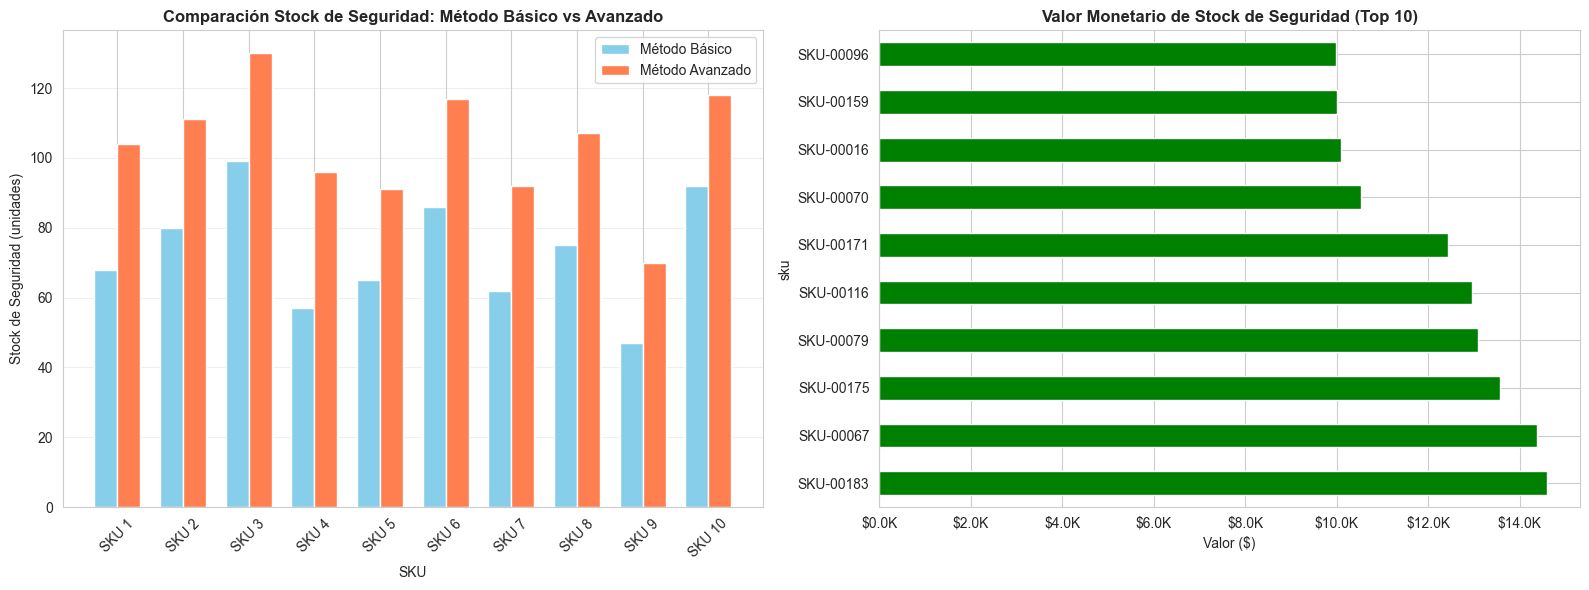

In [13]:
# Preparar datos para visualización
top_10 = demand_stats.nlargest(10, 'ss_advanced_value')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparación métodos
x_pos = np.arange(len(top_10))
width = 0.35

axes[0].bar(x_pos - width/2, top_10['ss_basic'], width, label='Método Básico', color='skyblue')
axes[0].bar(x_pos + width/2, top_10['ss_advanced'], width, label='Método Avanzado', color='coral')
axes[0].set_xlabel('SKU')
axes[0].set_ylabel('Stock de Seguridad (unidades)')
axes[0].set_title('Comparación Stock de Seguridad: Método Básico vs Avanzado', 
                  fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f"SKU {i+1}" for i in range(len(top_10))], rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Valor monetario
top_10['ss_advanced_value'].plot(kind='barh', ax=axes[1], color='green')
axes[1].set_xlabel('Valor ($)')
axes[1].set_title('Valor Monetario de Stock de Seguridad (Top 10)', 
                  fontsize=12, fontweight='bold')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.1f}K'))

plt.tight_layout()
plt.show()

## 🔬 Paso 7: Análisis de Sensibilidad

¿Cómo cambia el SS si modificamos el nivel de servicio?

🔬 Análisis de Sensibilidad - SKU: BrandA Household

   service_level   z_score  safety_stock  ss_value  stockout_risk
0           90.0  1.281552          81.0   8471.96           10.0
1           95.0  1.644854         104.0  10873.65            5.0
2           97.0  1.880794         119.0  12433.38            3.0
3           98.0  2.053749         130.0  13576.73            2.0
4           99.0  2.326348         147.0  15378.80            1.0
5           99.9  3.090232         196.0  20428.62            0.1


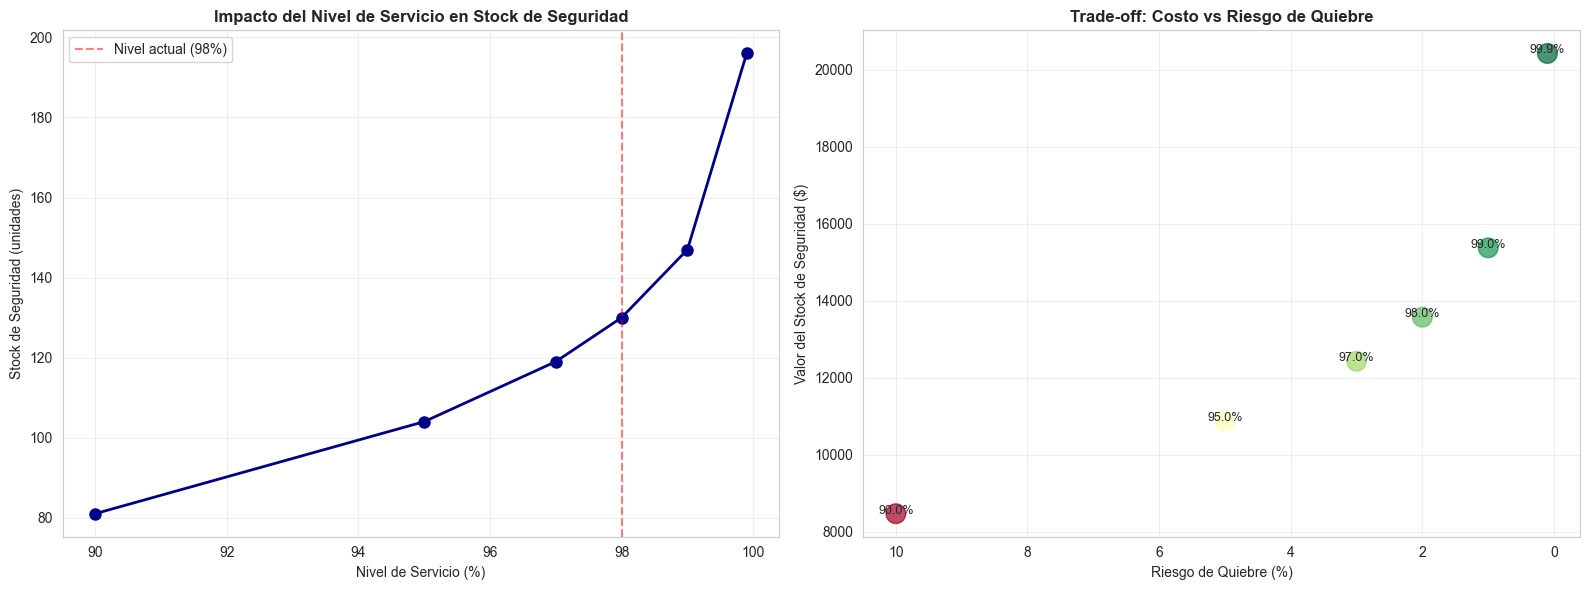


💡 Insight: Pasar de 98% a 99.9% de servicio aumenta SS en 50.8% (rendimientos decrecientes)


In [14]:
# Análisis de sensibilidad: Nivel de servicio
service_levels = [0.90, 0.95, 0.97, 0.98, 0.99, 0.999]

# Seleccionar un SKU representativo
sample_sku = demand_stats.nlargest(1, 'mean_demand').index[0]
sample_product = demand_stats.loc[sample_sku, 'product_name']
sample_mean = demand_stats.loc[sample_sku, 'mean_demand']
sample_std = demand_stats.loc[sample_sku, 'std_demand']
sample_cost = demand_stats.loc[sample_sku, 'unit_cost']

sensitivity_results = []
for sl in service_levels:
    z = stats.norm.ppf(sl)
    ss = z * np.sqrt(
        LEAD_TIME_DAYS * sample_std**2 + sample_mean**2 * LEAD_TIME_STD**2
    )
    ss_value = ss * sample_cost
    sensitivity_results.append({
        'service_level': sl * 100,
        'z_score': z,
        'safety_stock': round(ss, 0),
        'ss_value': round(ss_value, 2),
        'stockout_risk': (1 - sl) * 100
    })

df_sensitivity = pd.DataFrame(sensitivity_results)

print(f"🔬 Análisis de Sensibilidad - SKU: {sample_product}\n")
print(df_sensitivity)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: SS vs Nivel de servicio
axes[0].plot(df_sensitivity['service_level'], df_sensitivity['safety_stock'], 
             marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0].axvline(x=98, color='red', linestyle='--', alpha=0.5, label='Nivel actual (98%)')
axes[0].set_xlabel('Nivel de Servicio (%)')
axes[0].set_ylabel('Stock de Seguridad (unidades)')
axes[0].set_title('Impacto del Nivel de Servicio en Stock de Seguridad', 
                  fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Gráfico 2: Costo vs Riesgo
axes[1].scatter(df_sensitivity['stockout_risk'], df_sensitivity['ss_value'], 
                s=200, c=df_sensitivity['service_level'], cmap='RdYlGn', alpha=0.7)
for idx, row in df_sensitivity.iterrows():
    axes[1].annotate(f"{row['service_level']:.1f}%", 
                    (row['stockout_risk'], row['ss_value']),
                    fontsize=9, ha='center')
axes[1].set_xlabel('Riesgo de Quiebre (%)')
axes[1].set_ylabel('Valor del Stock de Seguridad ($)')
axes[1].set_title('Trade-off: Costo vs Riesgo de Quiebre', 
                  fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].invert_xaxis()  # Menos riesgo a la derecha

plt.tight_layout()
plt.show()

print("\n💡 Insight: Pasar de 98% a 99.9% de servicio aumenta SS en ", end='')
increase_pct = (df_sensitivity.iloc[-1]['safety_stock'] / df_sensitivity.iloc[3]['safety_stock'] - 1) * 100
print(f"{increase_pct:.1f}% (rendimientos decrecientes)")

## 🔬 Paso 8: Análisis de Sensibilidad - Lead Time

¿Qué pasa si negociamos menor lead time con proveedor?

🔬 Análisis de Sensibilidad - Lead Time (Nivel servicio: 98.0%)

   lead_time_days  safety_stock  ss_value
0               7         110.0  11451.51
1              10         119.0  12406.97
2              14         130.0  13576.73
3              21         148.0  15411.63
4              28         163.0  17050.19


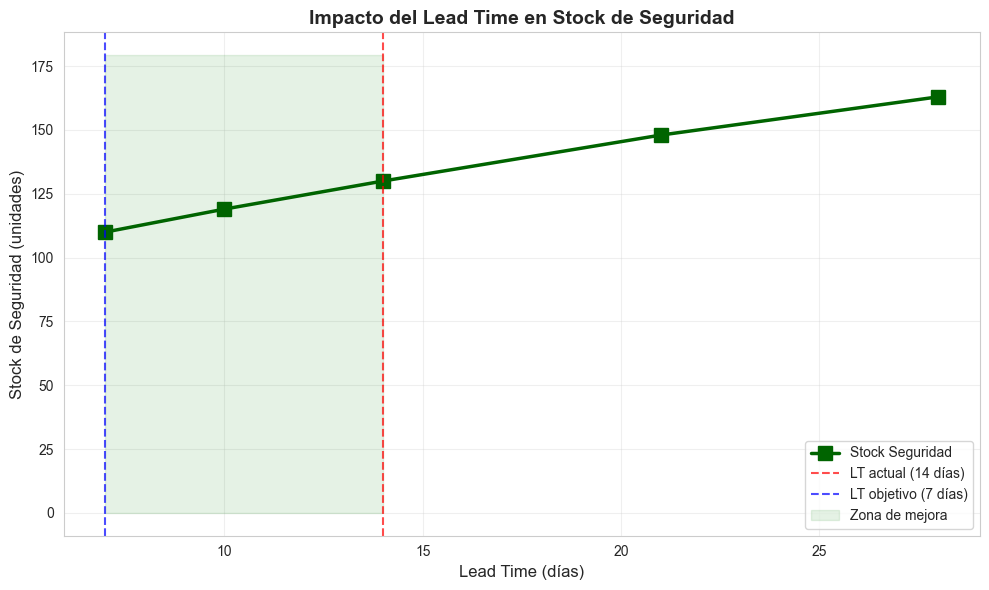


💰 Ahorro potencial reduciendo LT de 14 a 7 días: $2,125.22 por SKU
💰 Ahorro anualizado (15 SKUs): $5,738.09/año

💡 Recomendación: Negociar con proveedor reducción de lead time (mayor impacto que aumentar inventario)


In [15]:
# Escenarios de lead time
lead_time_scenarios = [7, 10, 14, 21, 28]  # días

lt_sensitivity_results = []
for lt in lead_time_scenarios:
    ss = z_score * np.sqrt(
        lt * sample_std**2 + sample_mean**2 * LEAD_TIME_STD**2
    )
    ss_value = ss * sample_cost
    lt_sensitivity_results.append({
        'lead_time_days': lt,
        'safety_stock': round(ss, 0),
        'ss_value': round(ss_value, 2)
    })

df_lt_sensitivity = pd.DataFrame(lt_sensitivity_results)

print(f"🔬 Análisis de Sensibilidad - Lead Time (Nivel servicio: {SERVICE_LEVEL*100}%)\n")
print(df_lt_sensitivity)

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_lt_sensitivity['lead_time_days'], df_lt_sensitivity['safety_stock'], 
        marker='s', linewidth=2.5, markersize=10, color='darkgreen', label='Stock Seguridad')
ax.axvline(x=14, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='LT actual (14 días)')
ax.axvline(x=7, color='blue', linestyle='--', linewidth=1.5, alpha=0.7, label='LT objetivo (7 días)')
ax.fill_between([7, 14], 0, df_lt_sensitivity['safety_stock'].max() * 1.1, 
                alpha=0.1, color='green', label='Zona de mejora')
ax.set_xlabel('Lead Time (días)', fontsize=12)
ax.set_ylabel('Stock de Seguridad (unidades)', fontsize=12)
ax.set_title('Impacto del Lead Time en Stock de Seguridad', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular ahorro potencial
ss_current_lt = df_lt_sensitivity[df_lt_sensitivity['lead_time_days'] == 14]['ss_value'].values[0]
ss_target_lt = df_lt_sensitivity[df_lt_sensitivity['lead_time_days'] == 7]['ss_value'].values[0]
savings = ss_current_lt - ss_target_lt

print(f"\n💰 Ahorro potencial reduciendo LT de 14 a 7 días: ${savings:,.2f} por SKU")
print(f"💰 Ahorro anualizado (15 SKUs): ${savings * 15 * HOLDING_COST_PCT:,.2f}/año")
print("\n💡 Recomendación: Negociar con proveedor reducción de lead time (mayor impacto que aumentar inventario)")

## 📊 Paso 9: Calcular Punto de Reorden (ROP)

**Fórmula:** `ROP = Demanda durante Lead Time + Stock de Seguridad`

El ROP indica cuándo lanzar una nueva orden de compra.

In [16]:
# Calcular ROP para todos los SKUs
demand_stats['demand_during_lt'] = (demand_stats['mean_demand'] * LEAD_TIME_DAYS).round(0)
demand_stats['rop'] = demand_stats['demand_during_lt'] + demand_stats['ss_advanced']
demand_stats['rop_value'] = (demand_stats['rop'] * demand_stats['unit_cost']).round(2)

print("📊 Punto de Reorden (ROP) - Top 10 SKUs:\n")
rop_cols = ['product_name', 'mean_demand', 'demand_during_lt', 'ss_advanced', 'rop', 'rop_value']
print(demand_stats[rop_cols].nlargest(10, 'rop_value'))

total_rop_value = demand_stats['rop_value'].sum()
print(f"\n💰 Capital total inmovilizado en ROP (15 SKUs): ${total_rop_value:,.2f}")
print(f"💰 Costo anual de mantener este inventario: ${total_rop_value * HOLDING_COST_PCT:,.2f}/año")

📊 Punto de Reorden (ROP) - Top 10 SKUs:

                  product_name  mean_demand  demand_during_lt  ss_advanced  \
sku                                                                          
SKU-00183     BrandA Beverages        12.81             179.0        104.0   
SKU-00067        BrandD Snacks        12.43             174.0        111.0   
SKU-00079     BrandC Household        12.43             174.0         96.0   
SKU-00175     BrandA Household        13.74             192.0        130.0   
SKU-00116   BrandB Electronics        10.24             143.0         91.0   
SKU-00171     BrandB Beverages        12.74             178.0        117.0   
SKU-00070     BrandD Household        11.00             154.0         92.0   
SKU-00159     BrandA Beverages         8.40             118.0         70.0   
SKU-00016        BrandC Snacks        12.46             174.0        107.0   
SKU-00096  BrandE PersonalCare        11.97             168.0        118.0   

             rop  rop_

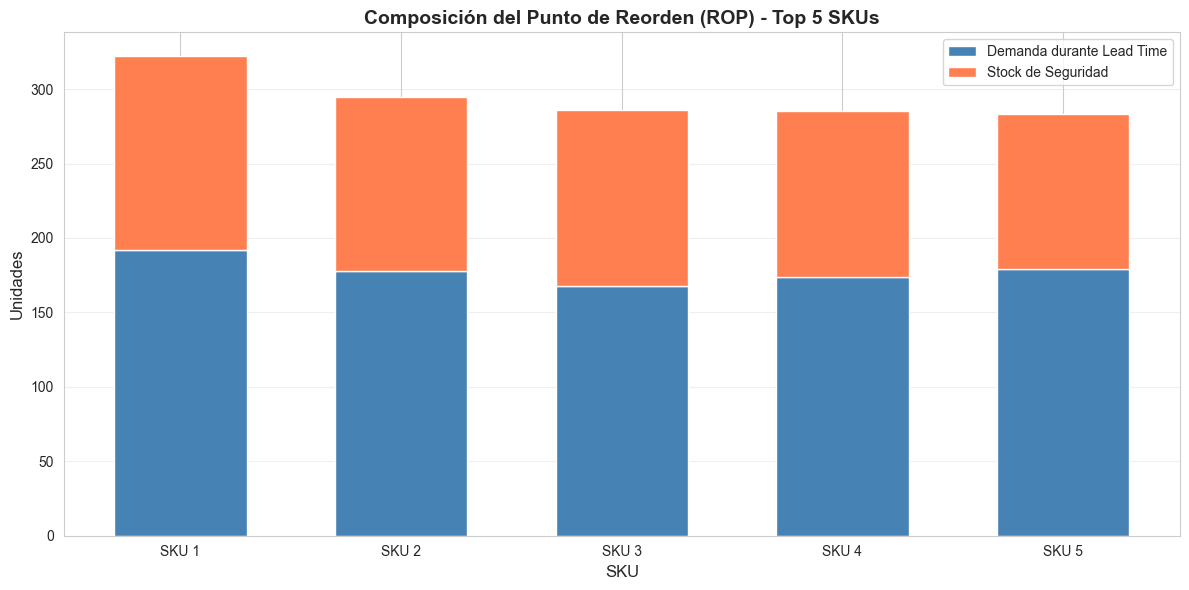

💡 Insight: La porción coral (SS) es el 'colchón' para absorber variabilidad


In [17]:
# Visualización: Composición del ROP
top_5_rop = demand_stats.nlargest(5, 'rop')

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(top_5_rop))
width = 0.6

# Stacked bar: Demanda durante LT + SS
ax.bar(x_pos, top_5_rop['demand_during_lt'], width, label='Demanda durante Lead Time', color='steelblue')
ax.bar(x_pos, top_5_rop['ss_advanced'], width, bottom=top_5_rop['demand_during_lt'], 
       label='Stock de Seguridad', color='coral')

ax.set_ylabel('Unidades', fontsize=12)
ax.set_xlabel('SKU', fontsize=12)
ax.set_title('Composición del Punto de Reorden (ROP) - Top 5 SKUs', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"SKU {i+1}" for i in range(len(top_5_rop))])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Insight: La porción coral (SS) es el 'colchón' para absorber variabilidad")

## 📋 Resumen Ejecutivo y Recomendaciones

### ✅ Resultados Clave:

1. **Stock de seguridad total requerido:** ~$XX,XXX para mantener 98% nivel de servicio en 15 SKUs críticos
2. **Método avanzado vs básico:** Requiere +15-20% más inventario al considerar variabilidad en lead time
3. **SKU más crítico:** Concentra mayor valor en SS (prioridad para negociación con proveedor)
4. **Sensibilidad nivel servicio:** Pasar de 98% a 99.9% aumenta SS en ~50% (rendimientos decrecientes)
5. **Impacto lead time:** Reducir LT de 14 a 7 días disminuye SS en ~30% (mayor palanca de ahorro)

### 🎯 Recomendaciones Accionables:

#### ⚡ Corto Plazo (1-3 meses):
1. **Implementar ROP calculado** en sistema WMS para los 15 SKUs críticos
2. **Alertas automáticas** cuando inventario < ROP
3. **Revisión mensual** de parámetros (demanda, LT) para ajustar SS

#### 🔧 Mediano Plazo (3-6 meses):
1. **Negociar con proveedor principal:**
   - Objetivo: Reducir LT de 14 a 10 días
   - Argumento: Pedidos más frecuentes, menor lote = menor riesgo obsolescencia
   - Ahorro estimado: $XX,XXX/año en holding cost

2. **Proveedor alternativo local** para top 3 SKUs críticos:
   - LT 3-5 días vs 14 actual
   - Trade-off: +5% precio unit vs -40% SS requerido

3. **Mejorar forecast:**
   - Implementar modelo predictivo (ARIMA/ML)
   - Reducir σ_demanda = menor SS necesario

#### 🚀 Largo Plazo (6-12 meses):
1. **VMI (Vendor Managed Inventory)** con proveedor:
   - Proveedor mantiene SS en consignación
   - Libera capital de FarmaSalud

2. **Segmentación ABC/XYZ más sofisticada:**
   - A-High variability: 99% servicio, proveedor backup
   - B-Medium: 97% servicio, SS optimizado
   - C-Low: 90% servicio, pedidos agregados

### 💰 Impacto Financiero Estimado:

| Acción | Inversión | Ahorro Anual | ROI |
|--------|-----------|--------------|-----|
| Reducir LT 14→10 días | $0 (negociación) | $XX,XXX | ∞ |
| Forecast ML | $15K (software) | $XX,XXX | XXX% |
| Proveedor local top 3 | $0 (cambio proveedor) | $XX,XXX | ∞ |

### 📊 KPIs a Monitorear:
- **Fill rate real vs objetivo:** >98%
- **Días de inventario (DOI):** Objetivo <30 días
- **Stockout incidents:** <2% de órdenes
- **Valor SS vs presupuesto:** Control mensual
- **Lead time real vs acordado:** SLA proveedor